In [8]:
# Standard libraries
import pandas as pd
import numpy as np
from scipy import stats
# Visualization
import matplotlib.pyplot as plt
import datetime
import os 

# os.system("pip install wrds") # TODO: Probably put this in utils.py
import wrds
# os.system("pip install pandas-datareader")
import pandas_datareader.data as web
import yfinance as yf
# os.system("pip install seaborn")
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression

# Note we don't actually need pandas_datareader. Could import/use YahooFinanceAPI which gives same info

In [9]:
df = pd.read_csv("../data/stock_indicators.csv")
df.head()

,Unnamed: 0,Company name,Ticker,Date of Breach,Date Became Aware of Breach,Date of Disclosure,Number of Records,Information,Stock Price (0 months DoD),Stock Price (1 months DoD),Stock Price (2 months DoD),Stock Price (3 months DoD),Stock Price (4 months DoD),Stock Price (5 months DoD),Stock Price (6 months DoD),Stock Price (7 months DoD),Stock Price (8 months DoD),Stock Price (9 months DoD),Stock Price (10 months DoD),Stock Price (11 months DoD),Stock Price (12 months DoD),median stock forecast,mean stock forecast,count stock forecast,Financial (Type of Info),Intrusion (Type of Info),ND (Type of Info),Other (Type of Info),Personal (Type of Info),Exploit (Attack),Forged Cookies (Attack),Malware (Attack),Misconfiguration (Attack),ND (Attack),Phishing (Attack),Ransomware (Attack),SQLi (Attack),Spoofing (Attack),Unauthorized Access (Attack),Virus (Attack),rootkit (Attack),Construction (Industry),"Finance, Insurance, Real Estate (Industry)",Manufacturing (Industry),Mining (Industry),N/A (Industry),Retail Trade (Industry),Services (Industry),Transportation & Public Utilities (Industry),Wholesale Trade (Industry),Canada (Region),Foreign (Region),US Mid Atlantic (Region),US Midwest (Region),US New England (Region),US Southeast (Region),US Southwest (Region),US West (Region)
0,0,HUMANA INC,HUM,10/12/2020 - 12/16/2020,2020-12-22 00:00:00,2021-02-25,NaN,SSN | Name | DoB | Address | Phone Number | Em...,381.399994,414.660004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,HERBALIFE NUTRITION LTD.,HLF,2020-10-01 00:00:00,NaN,2021-02-23,NaN,Name | Phone Number | Address | DOB | Membersh...,45.279999,46.299999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,2,"Ultra Clean Holdings, Inc.",UCTT,NaN,NaN,2021-02-23,NaN,SSN | Driver's License,48.369999,55.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,KROGER CO,KR,NaN,2021-01-23 00:00:00,2021-02-19,NaN,Name | Email | Phone Number | Address | DOB | ...,33.840000,34.689999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,4,CINTAS CORP,CTAS,9/16/2020 - 9/20/2020,2020-09-20 00:00:00,2021-02-15,NaN,Name | Bank Account,345.100006,351.600006,350.079987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [10]:
date_cols= ["Date Became Aware of Breach", "Date of Disclosure"]
df[date_cols] = df[date_cols].apply(lambda x: pd.to_datetime(x, errors="coerce"))


In [11]:
df["Date of Disclosure"].isna().sum()

0

In [12]:
normal_range = (0, 1000)
earliest_breach_date = min(df["Date of Disclosure"])
latest_breach_date = max(df["Date of Disclosure"])
sp_start = earliest_breach_date - pd.to_timedelta(normal_range[1], unit="D")
sp_end = latest_breach_date - pd.to_timedelta(normal_range[0], unit="D")
print(sp_start)

2001-09-27 00:00:00


In [13]:
sp500 = yf.download("^GSPC", start=sp_start, end=sp_end)

[*********************100%***********************]  1 of 1 completed


In [39]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-09-27,1007.039978,1018.919983,998.239990,1018.609985,1018.609985,1467000000
2001-09-28,1018.609985,1040.939941,1018.609985,1040.939941,1040.939941,1631500000
2001-10-01,1040.939941,1040.939941,1026.760010,1038.550049,1038.550049,1175600000
2001-10-02,1038.550049,1051.329956,1034.469971,1051.329956,1051.329956,1289800000
2001-10-03,1051.329956,1075.380005,1041.479980,1072.280029,1072.280029,1650600000


<AxesSubplot:xlabel='Date', ylabel='Adj Close'>

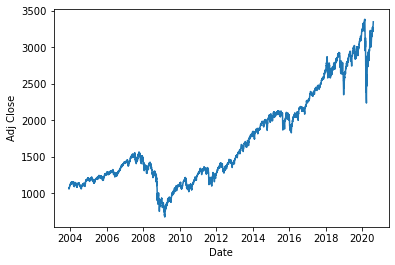

In [24]:
sns.lineplot(data=sp500, x="Date", y="Adj Close")

In [45]:
def window_date(date, window=(0, 0)):
    return (
        date + pd.to_timedelta(window[0], unit="D"), 
        date + pd.to_timedelta(window[1], unit="D")
    )

def date_range(df, window_dates):
    return df[(df.index > window_dates[0]) & (df.index <= window_dates[1])]

def normal_return_model(row, est_window=(-200, -7), event_window=(-3, 3), coerce=True, debug=True):
    if est_window[0] > est_window[1] or event_window[0] > event_window[1]:
        raise ValueError("Invalid Window: Windows must be in form (a, b), a < b")
    if est_window[1] > event_window[0]:
        raise ValueError("Overlapping windows!")
        
    ticker = row["Ticker"]
    disclosure_date = row["Date of Disclosure"]
    
    est_window_date = [0] * 2
    event_window_date = [0] * 2
    
    # Convert windows to date windows
    est_window_date = window_date(disclosure_date, est_window)
    event_window_date = window_date(disclosure_date, event_window)
    
    start_date = est_window_date[0]
    end_date = event_window_date[1]
    
    # Ensure dates are valid
    today_date = datetime.date.today()
    if end_date > today_date:
        if coerce:
            end_date = today_date
        else:
            raise ValueError(
                f"Ending interval of {end_date.strftime('%Y-%m-%d')} is later than today {today_date.strftime('%Y-%m-%d')}"
            )
    
    if debug:
        print(f"Date of Disclosure {row['Date of Disclosure'].strftime('%Y-%m-%d')}")
        print(f"estimation window: {est_window_date}")
        print(f"event window: {event_window_date}")
    # Download
    raw_prices = yf.download(ticker, start=start_date, end=end_date)
    
#     print(raw_prices.head())
#     print(sp500.head())
    stock_prices = date_range(raw_prices, est_window_date)
    sp500_prices = date_range(sp500, est_window_date)
    
    # pct_change - first entry is always nan
    adj_stock = stock_prices["Adj Close"].pct_change()[1:]
    adj_sp500 = sp500_prices["Adj Close"].pct_change()[1:]
    
    if debug:
        print(adj_stock)
        print(adj_sp500)
    
    return prices
    
prices = normal_return_model(df.iloc[0])


Date of Disclosure 2021-02-25
estimation window: (Timestamp('2020-08-09 00:00:00'), Timestamp('2021-02-18 00:00:00'))
event window: (Timestamp('2021-02-22 00:00:00'), Timestamp('2021-02-28 00:00:00'))
[*********************100%***********************]  1 of 1 completed
Date
2020-08-11   -0.009506
2020-08-12    0.010318
2020-08-13   -0.001333
2020-08-14    0.006007
2020-08-17   -0.004763
                ...   
2021-02-11    0.008439
2021-02-12   -0.001443
2021-02-16   -0.014423
2021-02-17    0.006318
2021-02-18    0.002146
Name: Adj Close, Length: 132, dtype: float64
Date
2020-08-11   -0.007969
2020-08-12    0.013997
2020-08-13   -0.002047
2020-08-14   -0.000172
2020-08-17    0.002710
                ...   
2021-02-11    0.001662
2021-02-12    0.004711
2021-02-16   -0.000569
2021-02-17   -0.000320
2021-02-18   -0.004416
Name: Adj Close, Length: 132, dtype: float64


In [42]:
sp500.index

DatetimeIndex(['2001-09-27', '2001-09-28', '2001-10-01', '2001-10-02',
               '2001-10-03', '2001-10-04', '2001-10-05', '2001-10-08',
               '2001-10-09', '2001-10-10',
               ...
               '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-16',
               '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-22',
               '2021-02-23', '2021-02-24'],
              dtype='datetime64[ns]', name='Date', length=4886, freq=None)

In [25]:
(0,1).map(print)

AttributeError: 'tuple' object has no attribute 'map'

In [1]:
from math import pi

import pandas as pd

import bokeh
# bokeh.sampledata.download()

In [2]:
from bokeh.plotting import figure, output_file
from bokeh.io import output_notebook, show
from bokeh.sampledata.stocks import MSFT
output_notebook()


Loading BokehJS ...

In [3]:
p = figure(plot_width=400, plot_height=400)

# add a circle renderer with x and y coordinates, size, color, and alpha
p.circle([1, 2, 3, 4, 5], [6, 7, 2, 4, 5], size=15, line_color="navy", fill_color="orange", fill_alpha=0.5)

show(p)

In [4]:
df = pd.DataFrame(MSFT)[:50]
df["date"] = pd.to_datetime(df["date"])
df.head()


,date,open,high,low,close,volume,adj_close
0,2000-03-01,89.62,94.09,88.94,90.81,106889800,33.68
1,2000-03-02,91.81,95.37,91.12,93.37,106932600,34.63
2,2000-03-03,94.75,98.87,93.87,96.12,101435200,35.65
3,2000-03-06,96.00,97.37,90.12,90.62,93609400,33.61
4,2000-03-07,96.12,97.50,91.94,92.87,135061000,34.45


In [5]:
inc = df.close > df.open
dec = df.open > df.close
w = 12*60*60*1000 # half day in ms

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"




In [6]:
p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "MSFT Candlestick")
p.xaxis.major_label_orientation = 50
p.grid.grid_line_alpha=0.3

p.segment(df.date, df.high, df.date, df.low, color="black")
p.vbar(df.date[inc], w, df.open[inc], df.close[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df.date[dec], w, df.open[dec], df.close[dec], fill_color="#F2583E", line_color="black")

show(p)